<a href="https://colab.research.google.com/github/abubakarali3/MSDS19086_COVID19_DLSpring2020/blob/master/MSDS19086_COVID19_DLSpring2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

**Load** **data**

In [0]:
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


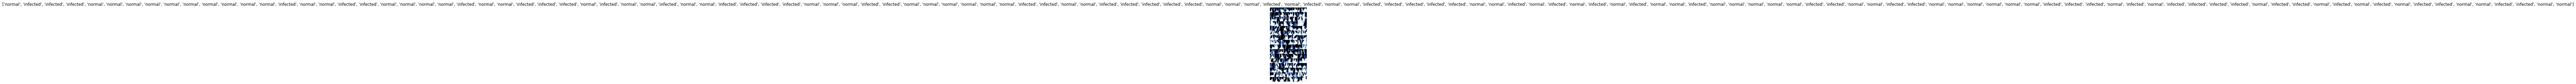

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=False)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


Task 1
Load pretrained models

In [7]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


**Fine Tuning on VGG16**

In [8]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)
print(num_features)

[]
25088


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
#(86*10)+100=960
features.extend(
    [
     nn.Linear(num_features,960),
     nn.Linear(960, len(class_names))])

In [11]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

Train Epoch: 0 [7296/12000 (61%)]	Loss: 0.640467: : 58it [1:35:43, 101.65s/it]

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses)

Testing

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)


**Accuracy

Testing Accuracy **


In [0]:
def Accuracy(network ,dataset):
  correct = 0
  total = 0
  inx = 0 
  predlist=torch.zeros(0,dtype=torch.long, device='cuda')
  lbllist=torch.zeros(0,dtype=torch.long, device='cuda')
  with torch.no_grad():
    for data in dataset:

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)

        predlist=torch.cat([predlist,predicted.view(-1)])
        lbllist=torch.cat([lbllist,labels.view(-1)])

        inx += 1
        print("\r Iterating on image batches : ",inx,end="")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  return (100*correct/total),predlist,lbllist

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label'

In [0]:
def F1_Score(conf_mat):
  TP = conf_mat[0][0]
  FN = conf_mat[0][1]
  FP = conf_mat[1][0]
  TN = conf_mat[1][1]

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)
  F1Score = 2*((Precision*Recall)/(Precision+Recall))

  print("Precision:",Precision)
  print("Recall:",Recall)
  print("F1 Score",F1Score)

In [0]:
t_acc , pr, lb = Accuracy(vgg16,testloader)
print("\n Testing Accuracy %d %%" % t_acc)

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

In [0]:
F1_Score(conf_mat)

**

Validation Accuracy & Confusion Matrix
**

In [0]:


acc, pred, lbls = Accuracy(vgg16,validloader)
print('\nAccuracy of the network on the Validation images: %d %%' % acc)

# confusion matrix for testing 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)



In [0]:
F1_Score(conf_mat)

**Training Accuracy & Confusion Matrix**

In [0]:
acc, pred, lbls = Accuracy(vgg16,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

In [0]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

**Testing**

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))